In [2]:
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from WiSARD import WiSARD
import numpy as np
import pandas as pd
import math
import sys
import random
import matplotlib.pyplot as plt
import itertools
from Utils import thermometer,one_hot

pd.options.mode.chained_assignment = None  # default='warn'

import seaborn as sns
color = sns.color_palette()
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
qtd_splits = 10
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import svm
from time import time
from collections import defaultdict

import itertools
#import xgboost as xgb

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#model = KeyedVectors.load_word2vec_format('../glove.6B.50d.word2vec.txt')

In [5]:
df = {
    "cooking": pd.read_csv('../dataset/processed/cooking.csv'),
    "crypto": pd.read_csv('../dataset/processed/crypto.csv'),
    "robotics": pd.read_csv('../dataset/processed/robotics.csv'),
    "biology": pd.read_csv('../dataset/processed/biology.csv'),
    "travel": pd.read_csv('../dataset/processed/travel.csv'),
    "diy": pd.read_csv('../dataset/processed/diy.csv'),
    #"physics": pd.read_csv('physics.csv'),
}

X = []
y = []

for file in df:
    for i in range(df[file].shape[0]):
        doc = ''
        if type(df[file].iloc[i]['title']) is str:
            doc += df[file].iloc[i]['title'] + ' '
        if type(df[file].iloc[i]['content']) is str:
            doc += df[file].iloc[i]['content'] + ' '
            X.append(doc)
            y.append(file)
    #f = pd.DataFrame(X)
    #f.to_csv("../dataset/word2vec/" + file + ".csv", index=False)

In [6]:
l_enc = LabelEncoder()
y_enc = l_enc.fit_transform(y)
print('Encoded labels: ', list([(i, l_enc.classes_[i]) for i in range(0, len(l_enc.classes_))]))

Encoded labels:  [(0, 'biology'), (1, 'cooking'), (2, 'crypto'), (3, 'diy'), (4, 'robotics'), (5, 'travel')]


## Functions 

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
      
    plt.figure(figsize=(12,6))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.title(title + " normalized confusion matrix")
    else:
        plt.title(title + ' confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #print(cm)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    

def benchmark(clf, X_train, y_train, X_test, y_test):

    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    
    cm = confusion_matrix(y_test, pred)  
    
    clf_descr = str(clf).split('(')[0]
    print("Done with " + clf_descr)
    print('_' * 80)
    
    return clf_descr, score, train_time, test_time, cm

def show_results(cf, name):
    print(name)
    print(cf)
    print('\n')
    print('Mean accuracy: ' + str((np.array(cf['score'])).mean()) + ' +/- ' + str((np.array(cf['score'])).std()))
    print('Mean train time: ' + str((np.array(cf['train_time'])).mean()) + ' +/- ' + str((np.array(cf['train_time'])).std()))
    print('Mean test time: ' + str((np.array(cf['test_time'])).mean()) + ' +/- ' + str((np.array(cf['test_time'])).std()))
    print('Mean confusion matrix:')
    
    t = [np.matrix(x) for x in cf['confusion_matrix']]
    su = np.matrix(t[0])
    for i in range(1,len(t)):
        su += t[i]
    plot_confusion_matrix(np.squeeze(np.asarray(su)), l_enc.classes_, title=name, normalize=True)
    
    print('_' * 80)

In [8]:
#sv = CountVectorizer(binary=True, max_df=0.7, min_df=300)
#X_bow = sv.fit_transform(X)

sv = TfidfVectorizer(analyzer='word', ngram_range=(1,1), max_df=0.7, min_df=2, sublinear_tf=True)
X_bow = sv.fit_transform(X)

In [9]:
len(sv.vocabulary_)

37202

In [10]:
svd = TruncatedSVD(n_components=50, algorithm='randomized')
X_svd = svd.fit_transform(X_bow)
print('Shape of svd matrix: ', X_svd.shape)

Shape of svd matrix:  (86998, 50)


In [24]:
X_onehot = []
for i in range(len(X_svd)):
    X_onehot.append(one_hot(X_svd[i], n=50))

## Kfold

In [11]:
X_train = np.array(X_svd)
y_train = np.array(y_enc)

kf = StratifiedKFold(n_splits=10)

#results = defaultdict(list)
resultsGaussianNB = { 'score': [], 'train_time': [], 'test_time': [], 'confusion_matrix': [] }
resultsBernoulliNB = { 'score': [], 'train_time': [], 'test_time': [], 'confusion_matrix': [] }
resultsRandomForest = { 'score': [], 'train_time': [], 'test_time': [], 'confusion_matrix': [] }
resultsSVM = { 'score': [], 'train_time': [], 'test_time': [], 'confusion_matrix': [] }
resultsWisardThermometer = { 'score': [], 'train_time': [], 'test_time': [], 'confusion_matrix': [] }
resultsWisardOneHot = { 'score': [], 'train_time': [], 'test_time': [], 'confusion_matrix': [] }


for train, test in kf.split(X_train, y_train):
    clfr = benchmark(GaussianNB(), X_train[train], y_train[train], X_train[test], y_train[test])
    resultsGaussianNB['score'].append(clfr[1])
    resultsGaussianNB['train_time'].append(clfr[2])
    resultsGaussianNB['test_time'].append(clfr[3])
    resultsGaussianNB['confusion_matrix'].append(clfr[4])

for train, test in kf.split(X_train, y_train):
    clfr = benchmark(BernoulliNB(), X_train[train], y_train[train], X_train[test], y_train[test])
    resultsBernoulliNB['score'].append(clfr[1])
    resultsBernoulliNB['train_time'].append(clfr[2])
    resultsBernoulliNB['test_time'].append(clfr[3])
    resultsBernoulliNB['confusion_matrix'].append(clfr[4])

for train, test in kf.split(X_train, y_train):
    clfr = benchmark(RandomForestClassifier(), X_train[train], y_train[train], X_train[test], y_train[test])
    resultsRandomForest['score'].append(clfr[1])
    resultsRandomForest['train_time'].append(clfr[2])
    resultsRandomForest['test_time'].append(clfr[3])
    resultsRandomForest['confusion_matrix'].append(clfr[4])

for train, test in kf.split(X_train, y_train):
    clfr = benchmark(svm.LinearSVC(), X_train[train], y_train[train], X_train[test], y_train[test])
    resultsSVM['score'].append(clfr[1])
    resultsSVM['train_time'].append(clfr[2])
    resultsSVM['test_time'].append(clfr[3])
    resultsSVM['confusion_matrix'].append(clfr[4])
    


Training: 
GaussianNB(priors=None)
train time: 0.165s
test time:  0.088s
accuracy:   0.825
Done with GaussianNB
________________________________________________________________________________
Training: 
GaussianNB(priors=None)
train time: 0.208s
test time:  0.059s
accuracy:   0.853
Done with GaussianNB
________________________________________________________________________________
Training: 
GaussianNB(priors=None)
train time: 0.118s
test time:  0.058s
accuracy:   0.859
Done with GaussianNB
________________________________________________________________________________
Training: 
GaussianNB(priors=None)
train time: 0.108s
test time:  0.050s
accuracy:   0.864
Done with GaussianNB
________________________________________________________________________________
Training: 
GaussianNB(priors=None)
train time: 0.106s
test time:  0.046s
accuracy:   0.871
Done with GaussianNB
________________________________________________________________________________
Training: 
GaussianNB(priors=None)


All results


Naïve-Bayes Gaussian
{'score': [0.82486784647207534, 0.85290737761434154, 0.85944144351223994, 0.86357889897712903, 0.87091954022988505, 0.88436781609195403, 0.87216921485228183, 0.87883664789056215, 0.86916532536215219, 0.86844526218951246], 'train_time': [0.16512346267700195, 0.20763683319091797, 0.11759328842163086, 0.1080789566040039, 0.10608077049255371, 0.1161031723022461, 0.13283085823059082, 0.10307502746582031, 0.10257959365844727, 0.12410330772399902], 'test_time': [0.08807110786437988, 0.05853748321533203, 0.05803966522216797, 0.05003070831298828, 0.04603099822998047, 0.0510406494140625, 0.06104016304016113, 0.05503535270690918, 0.04563546180725098, 0.04453706741333008], 'confusion_matrix': [array([[1195,   34,    4,   34,   24,   29],
       [ 167, 1282,    4,   68,    6,   14],
       [  70,    2,  929,    7,   24,   12],
       [ 166,  154,    3, 1991,   61,  217],
       [  33,    2,    2,    7,  226,    7],
       [ 304,   41,    1,   22,    5, 1555]]), ar

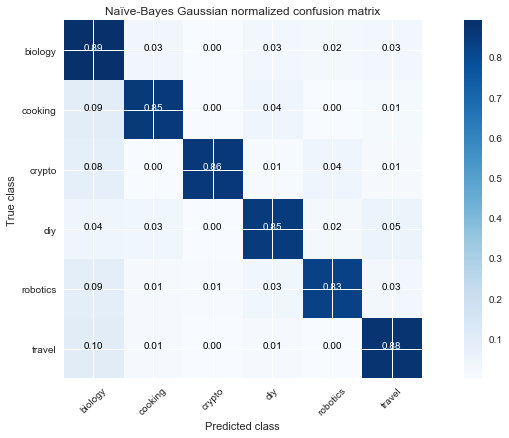

________________________________________________________________________________
Naïve-Bayes Bernoulli
{'score': [0.87382210985980235, 0.87853367042059294, 0.87817492242271, 0.87748534651189514, 0.88229885057471269, 0.88827586206896547, 0.87883664789056215, 0.8805609840211519, 0.88744538974476894, 0.87373505059797607], 'train_time': [0.13910174369812012, 0.14163970947265625, 0.14310646057128906, 0.16128087043762207, 0.15411162376403809, 0.1461009979248047, 0.1601095199584961, 0.14810633659362793, 0.14910411834716797, 0.14609718322753906], 'test_time': [0.022012710571289062, 0.01801323890686035, 0.015009641647338867, 0.01601386070251465, 0.017012834548950195, 0.015010833740234375, 0.015516042709350586, 0.016016721725463867, 0.01501607894897461, 0.015012502670288086], 'confusion_matrix': [array([[1131,   41,    9,   56,   22,   61],
       [  95, 1283,    5,   97,    1,   60],
       [  80,    9,  872,    4,   15,   64],
       [  73,   67,   24, 2333,   16,   79],
       [  24,   12,   

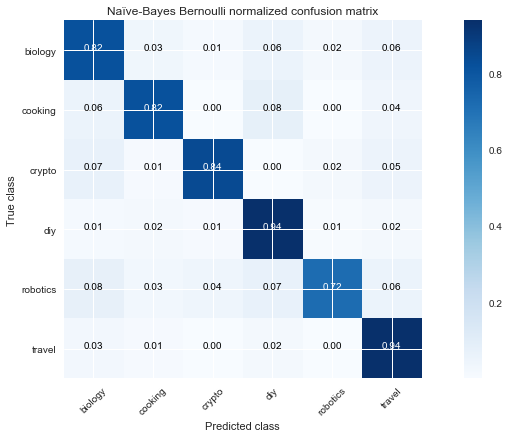

________________________________________________________________________________
Random Forest
{'score': [0.90255113766950124, 0.92174212824638013, 0.91885990116078609, 0.9172508907022181, 0.91873563218390808, 0.93068965517241375, 0.92022071502471547, 0.92723301528911373, 0.92527017705219594, 0.92076816927322902], 'train_time': [9.187863111495972, 8.89586591720581, 9.337196350097656, 9.093255281448364, 9.3683443069458, 8.915059804916382, 9.621538639068604, 8.971104621887207, 9.05980634689331, 9.027398586273193], 'test_time': [0.02501821517944336, 0.02402210235595703, 0.02302074432373047, 0.023021459579467773, 0.023020267486572266, 0.02452397346496582, 0.04103732109069824, 0.023520946502685547, 0.023018360137939453, 0.0250241756439209], 'confusion_matrix': [array([[1203,   42,    9,   29,   10,   27],
       [  86, 1389,    1,   43,    1,   21],
       [  40,    7,  982,    4,    3,    8],
       [  88,   88,    4, 2370,    6,   36],
       [  62,    5,   17,   39,  146,    8],
       [

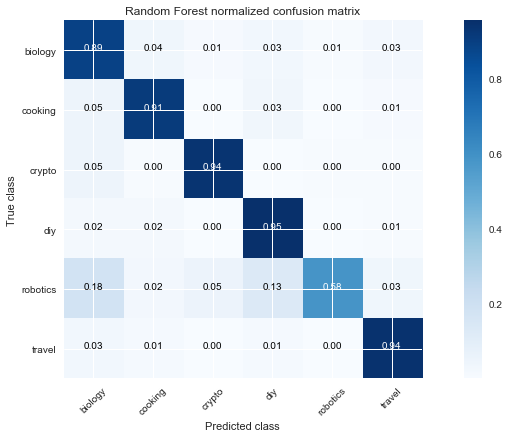

________________________________________________________________________________
SVM
{'score': [0.94461043438290049, 0.95185014939094459, 0.94908631191817028, 0.94943109987357777, 0.94758620689655171, 0.95908045977011491, 0.94826991608230826, 0.95378779170019545, 0.95665670269027359, 0.94744710211591532], 'train_time': [2.920375347137451, 3.1776652336120605, 3.2092134952545166, 3.375819206237793, 3.21879243850708, 3.100564479827881, 3.2224838733673096, 3.0142135620117188, 3.079392910003662, 3.0784120559692383], 'test_time': [0.0030007362365722656, 0.003003358840942383, 0.0035033226013183594, 0.0020017623901367188, 0.002003908157348633, 0.003003358840942383, 0.0030014514923095703, 0.003003835678100586, 0.003005504608154297, 0.002002239227294922], 'confusion_matrix': [array([[1246,   29,    4,   17,    7,   17],
       [  29, 1455,    1,   34,    1,   21],
       [  17,    6, 1009,    3,    2,    7],
       [  44,   60,    5, 2445,    8,   30],
       [  19,    1,   10,   24,  216,    7]

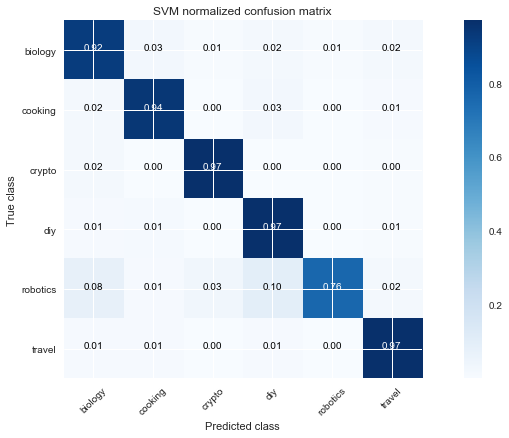

________________________________________________________________________________


In [12]:
print('All results')
print('\n')

show_results(resultsGaussianNB, 'Naïve-Bayes Gaussian')
show_results(resultsBernoulliNB, 'Naïve-Bayes Bernoulli')
show_results(resultsRandomForest, 'Random Forest')
show_results(resultsSVM, 'SVM')

In [25]:
X_train = np.array(X_onehot)
y_train = np.array(y_enc)

kf = StratifiedKFold(n_splits=10)

resultsWisardOneHot = { 'score': [], 'train_time': [], 'test_time': [], 'confusion_matrix': [] }

#X_train = np.array(X_onehot)
for train, test in kf.split(X_train, y_train):
    clfr = benchmark(WiSARD(4, seed=random.randint(0, 2**32-1), ignore_zero_addr=True), X_train[train], y_train[train], X_train[test], y_train[test])
    resultsWisardOneHot['score'].append(clfr[1])
    resultsWisardOneHot['train_time'].append(clfr[2])
    resultsWisardOneHot['test_time'].append(clfr[3])
    resultsWisardOneHot['confusion_matrix'].append(clfr[4])

Training: 
train time: 1276.360s
test time:  2255.482s
accuracy:   0.340
Done with <WiSARD.WiSARD object at 0x000002CE46407390>
________________________________________________________________________________
Training: 
train time: 1272.133s
test time:  2223.470s
accuracy:   0.341
Done with <WiSARD.WiSARD object at 0x000002CE4DF605F8>
________________________________________________________________________________
Training: 
train time: 1253.799s
test time:  2239.600s
accuracy:   0.317
Done with <WiSARD.WiSARD object at 0x000002CE46407390>
________________________________________________________________________________
Training: 
train time: 1253.264s
test time:  2209.860s
accuracy:   0.314
Done with <WiSARD.WiSARD object at 0x000002CE46407390>
________________________________________________________________________________
Training: 
train time: 1252.742s
test time:  2200.493s
accuracy:   0.312
Done with <WiSARD.WiSARD object at 0x000002CE46407390>
____________________________________

WiSARD with One Hot
{'score': [0.33992185704435762, 0.34072626982302917, 0.31743477761176875, 0.31398689805769453, 0.31195402298850577, 0.30287356321839082, 0.30923094608575696, 0.31072537073226808, 0.31593469763163945, 0.30565777368905245], 'train_time': [1276.3596408367157, 1272.1333692073822, 1253.7994153499603, 1253.264154434204, 1252.741590499878, 1299.3914127349854, 1244.6133015155792, 1247.5686864852905, 1278.6041429042816, 1246.7788755893707], 'test_time': [2255.4820642471313, 2223.469727754593, 2239.5999228954315, 2209.8601932525635, 2200.4932997226715, 2223.8832762241364, 2180.312333583832, 2232.2804923057556, 2155.770850419998, 2284.517964363098], 'confusion_matrix': [array([[   1,    0,    0, 1294,    0,   25],
       [   0,    8,    0, 1530,    0,    3],
       [   0,    0,    1, 1041,    0,    2],
       [   0,    0,    0, 2587,    0,    5],
       [   0,    0,    0,  274,    0,    3],
       [   0,    0,    0, 1567,    0,  361]]), array([[   0,    0,    0, 1287,    0,   

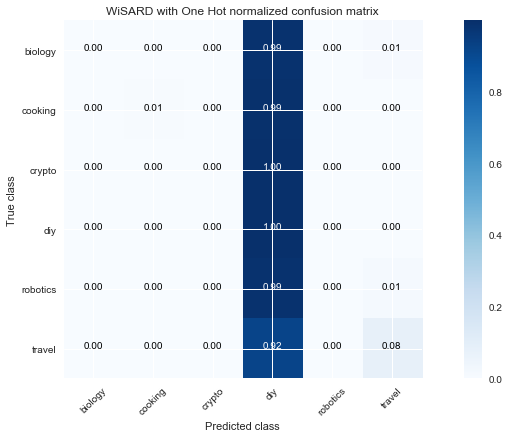

________________________________________________________________________________


In [ ]:
#show_results(resultsWisardThermometer, 'WiSARD with Thermometer')
show_results(resultsWisardOneHot, 'WiSARD with One Hot')